In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader 
from itertools import islice


from AE_functions import *
from eval_functions import *
from make_dataset import * 

# %matplotlib qt

import warnings
warnings.filterwarnings("ignore")


In [2]:
## Define which training model, that should be evaluated

train = '50682'

_____________________________

In [101]:
## Loading test image + outlier image

# Loading data (testset, 41 elements)
img_dir_test = "G:/Mit drev/Uni/6. semester/JK_bachelor/Data/Verse20/Outlier_detection/crops_validation_prep/img"
heatmap_dir_test = "G:/Mit drev/Uni/6. semester/JK_bachelor/Data/Verse20/Outlier_detection/crops_validation_prep/heatmaps"
msk_dir_test = "G:/Mit drev/Uni/6. semester/JK_bachelor/Data/Verse20/Outlier_detection/crops_validation_prep/msk"

VerSe_test = LoadData(img_dir=img_dir_test, msk_dir = msk_dir_test, distfield_dir=heatmap_dir_test)
test_loader = DataLoader(VerSe_test, batch_size=1, shuffle=False, num_workers=0)

healthy, outlier = healthy_outlier(test_loader)
print(len(healthy))
print(len(outlier))


# Create datasets
dataset_healthy = generate_dataset(healthy, 120)
dataset_outlier = generate_dataset_outlier(outlier, 120, radius=30, mode="black")



24
24


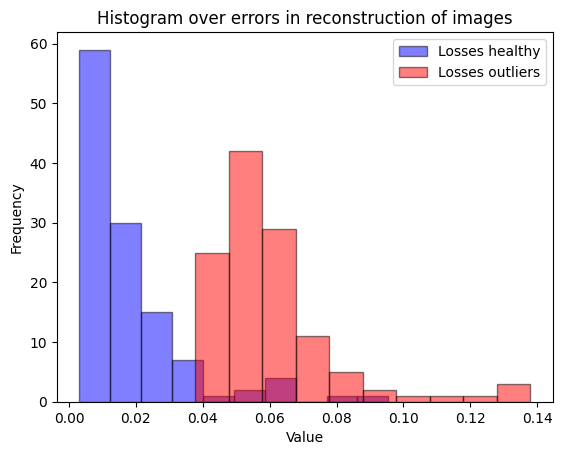

In [102]:
## Evaluating the model with new data (healthy and outliers)

# Loading the model
model_path = f'G:/Mit drev/Uni/6. semester/JK_bachelor/{train}_training/model_conv_999.pth'

model = load_model(model_path, [1, 16, 32, 64, 128])

# Testing the model
error_healthy = []
error_outlier = []

for i in range(len(dataset_healthy)):
    # test_healthy, _, _  = test_loader.dataset[i]
    test_healthy = dataset_healthy[i]
    loss = evaluate_model(model, test_healthy[0].unsqueeze(dim=0))
    error_healthy.append(loss)

    # test_outlier, _, _ = test_loader_o.dataset[i]
    test_outlier = dataset_outlier[i]
    loss = evaluate_model(model, test_outlier[0].unsqueeze(dim=0))
    error_outlier.append(loss)


hist_values1, hist_values2, bins1, bins2 = plot_histograms(error_healthy, error_outlier, 10)

mean_healthy = np.mean(error_healthy)
std_healthy = np.std(error_healthy)

mean_outlier = np.mean(error_outlier)
std_outlier = np.std(error_outlier)

In [103]:
print(f"Mean healthy: {mean_healthy}, std healthy: {std_healthy}")
print(f"Mean outlier: {mean_outlier}, std outlier: {std_outlier}")

Mean healthy: 0.01838989181172413, std healthy: 0.016054501021264996
Mean outlier: 0.060113311652094124, std outlier: 0.018427869549148147


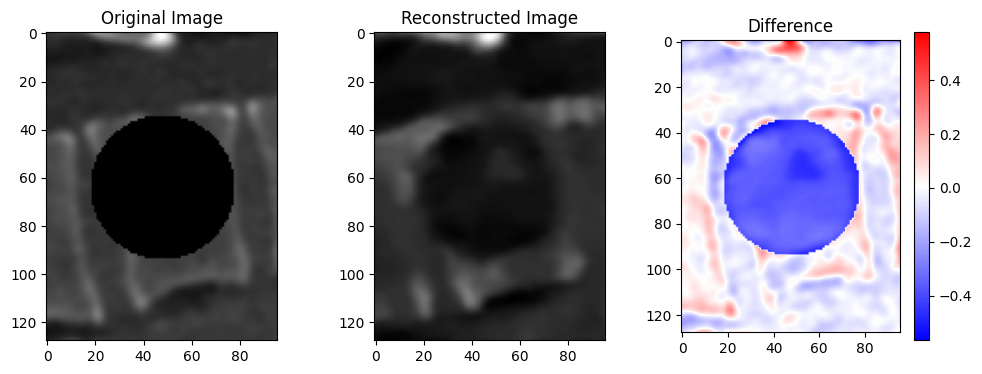

In [104]:
## Plotting the difference from outlier input to reconstructions
org_img = dataset_outlier[0].squeeze()
reconstructed_img = model(dataset_outlier[0].unsqueeze(dim=0)).squeeze().detach().numpy()

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(dataset_outlier[0].squeeze(), cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(reconstructed_img, cmap='gray')
ax[1].set_title('Reconstructed Image')

ax[2].imshow(org_img - reconstructed_img, cmap='bwr')
ax[2].set_title('Difference')
fig.colorbar(ax[2].imshow(org_img - reconstructed_img, cmap='bwr'))

plt.show()


# SSIM

The mean structural similarity index over the image is: 0.7435602504702349


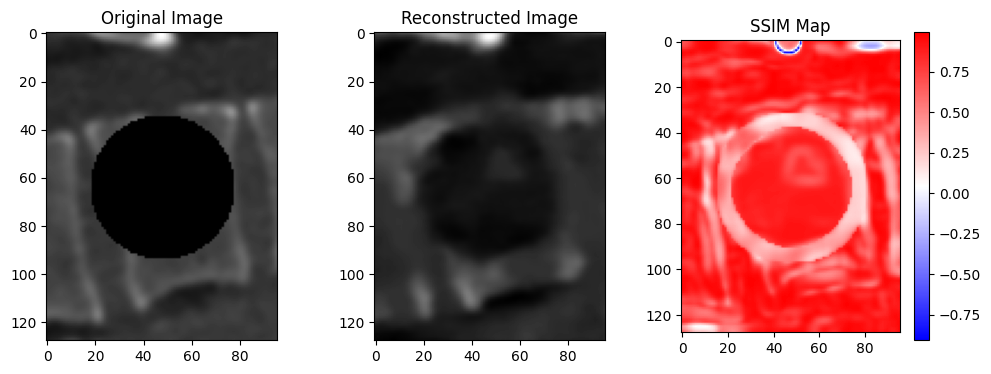

In [105]:
import numpy as np
from skimage.metrics import structural_similarity as ssim

org_img_np = org_img.cpu().detach().numpy()
reconstructed_img_np = reconstructed_img.astype(np.float64)


# Compute SSIM
mssim, ssim_map  = ssim(org_img_np, reconstructed_img_np, full=True)
print('The mean structural similarity index over the image is:',mssim)
#plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].imshow(org_img_np, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(reconstructed_img_np, cmap='gray')
ax[1].set_title('Reconstructed Image')

ax[2].imshow(ssim_map, cmap='bwr')
ax[2].set_title('SSIM Map')
fig.colorbar(ax[2].imshow(ssim_map, cmap='bwr'))

plt.show()

# PCA

(128, 16, 12)


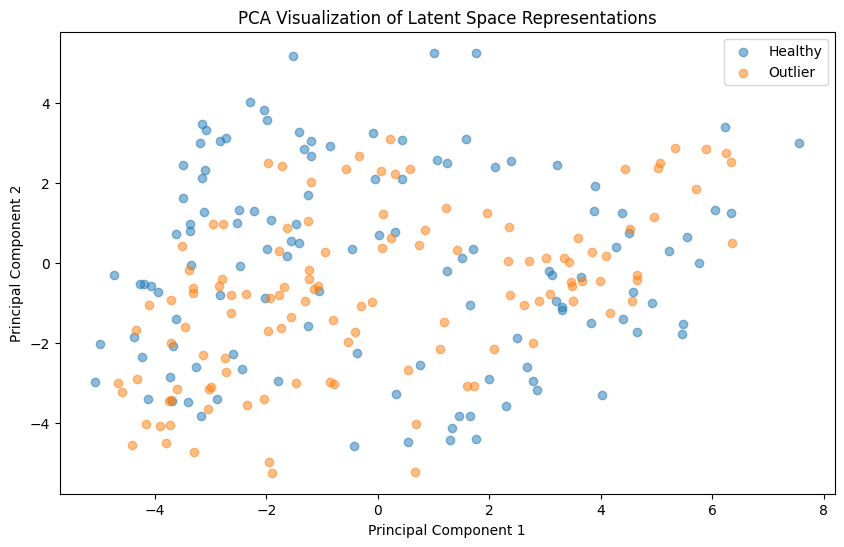

In [37]:
from sklearn.decomposition import PCA
# Collect latent representations for healthy and outlier data
latent_representations_healthy = collect_latent_representations(model, dataset_healthy)
latent_representations_outlier = collect_latent_representations(model, dataset_outlier)

print(latent_representations_healthy[0].shape)

# Flatten the collected latent representations
latent_representations_healthy_flat = np.concatenate([latent.flatten().reshape(1, -1) for latent in latent_representations_healthy], axis=0)
latent_representations_outlier_flat = np.concatenate([latent.flatten().reshape(1, -1) for latent in latent_representations_outlier], axis=0)



# Now, you can perform PCA on these flattened latent representations
# For example:

pca = PCA(n_components=2)  # Adjust the number of components as needed
pca.fit(latent_representations_healthy_flat)

# Transform both healthy and outlier latent representations using the PCA model
latent_healthy_pca = pca.transform(latent_representations_healthy_flat)
latent_outlier_pca = pca.transform(latent_representations_outlier_flat)

# Now you can analyze the transformed representations using PCA

# Visualize transformed representations
plt.figure(figsize=(10, 6))

# Plot healthy data
plt.scatter(latent_healthy_pca[:, 0], latent_healthy_pca[:, 1], label='Healthy', alpha=0.5)

# Plot outlier data
plt.scatter(latent_outlier_pca[:, 0], latent_outlier_pca[:, 1], label='Outlier', alpha=0.5)

plt.title('PCA Visualization of Latent Space Representations')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(False)
plt.show()


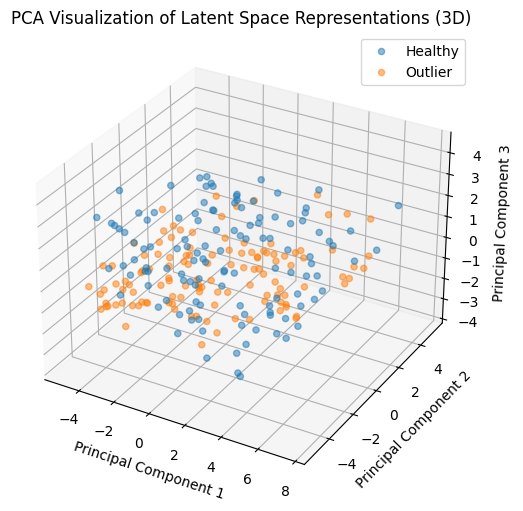

In [38]:
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA with 3 components
pca = PCA(n_components=3)
pca.fit(latent_representations_healthy_flat)

# Transform both healthy and outlier latent representations using the PCA model
latent_healthy_pca = pca.transform(latent_representations_healthy_flat)
latent_outlier_pca = pca.transform(latent_representations_outlier_flat)

# Visualize transformed representations in a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot healthy data
ax.scatter(latent_healthy_pca[:, 0], latent_healthy_pca[:, 1], latent_healthy_pca[:, 2], label='Healthy', alpha=0.5)

# Plot outlier data
ax.scatter(latent_outlier_pca[:, 0], latent_outlier_pca[:, 1], latent_outlier_pca[:, 2], label='Outlier', alpha=0.5)

ax.set_title('PCA Visualization of Latent Space Representations (3D)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()
